In [178]:
import pandas as pd
import numpy as np
import sodapy # Dataset fetching
import urllib # URL encoding and requesting
import json # Read URL request results
from sklearn.neighbors import KernelDensity # KDE algorithm
from sklearn.model_selection import GridSearchCV, LeaveOneOut # Cross-validation for parameter tuning (small datasets)
import matplotlib.pyplot as plt # Plotting final contour results

### Read in childcare provider data

Data source: <a href = "https://data.vermont.gov/Education/Vermont-Child-Care-Provider-Data/ctdw-tmfz/data">VT open data portal</a>

Using `Sodapy` API reader, <a href = "https://dev.socrata.com/foundry/data.vermont.gov/ctdw-tmfz">explanation of usage (specific to VT child care provider dataset) here</a>

Requesting only information relevant to location and capacity

Note: V2 = parse by age population to make need comparison

In [93]:
client = sodapy.Socrata('data.vermont.gov',
                 'my_key',
                 username = 'my_email',
                 password = 'my_password')

In [94]:
results = client.get('ctdw-tmfz', select = 'provider_id, address_1, address_2, provider_town, zip_code, county, total_licensed_capacity', limit = 2500)

In [95]:
data = pd.DataFrame.from_records(results)

In [96]:
data.shape

(1156, 7)

In [97]:
data.head()

,provider_id,address_1,address_2,provider_town,zip_code,county,total_licensed_capacity
0,3805,84 Grange Hall Road,Clarendon Elementary School,Clarendon,05759,Rutland,60
1,286886,4515 VT Route 109,0,Belvidere,05442,Lamoille,16
2,28342,3 Willow Lane,0,Jericho,05465,Chittenden,10
3,24009,1,0,Lyndon,05851,Caledonia,10
4,3354,234 North Main Street,0,Danby,05739,Rutland,50


Create full address field for lat/lon lookup

In [98]:
data['full_address'] = data['address_1'] + ' ' + data['provider_town'] + ' ' + data['zip_code']

### Make Google Maps API request for lat/lon of each provider and map to dataframe

<a href = "https://developers.google.com/maps/documentation/geocoding/overview">Google Maps API geocoding reference here</a>

In [99]:
key = 'my_key'

In [100]:
base_url = 'https://maps.googleapis.com/maps/api/geocode/json?'

In [101]:
provider_id_address_dict = pd.Series(data['full_address'].values, index = data['provider_id']).to_dict()

In [107]:
provider_lat_dict = {}
provider_lon_dict = {}
for provider in provider_id_address_dict.keys() :
    address = provider_id_address_dict[provider]
    query_url = base_url + urllib.parse.urlencode({'address': address, 'key': key})
    request_result = urllib.request.urlopen(query_url)
    result_data = request_result.read().decode()
    result_js_data = json.loads(result_data)
    lat = result_js_data['results'][0]['geometry']['location']['lat']
    lon = result_js_data['results'][0]['geometry']['location']['lng']
    provider_lat_dict[provider] = lat
    provider_lon_dict[provider] = lon

In [108]:
data['Lat'] = data['provider_id'].map(provider_lat_dict)
data['Lon'] = data['provider_id'].map(provider_lon_dict)

In [109]:
data.head()

,provider_id,address_1,address_2,provider_town,zip_code,county,total_licensed_capacity,full_address,Lat,Lon
0,3805,84 Grange Hall Road,Clarendon Elementary School,Clarendon,05759,Rutland,60,84 Grange Hall Road Clarendon 05759,43.563400,-72.967860
1,286886,4515 VT Route 109,0,Belvidere,05442,Lamoille,16,4515 VT Route 109 Belvidere 05442,44.747093,-72.701528
2,28342,3 Willow Lane,0,Jericho,05465,Chittenden,10,3 Willow Lane Jericho 05465,44.519144,-72.954748
3,24009,1,0,Lyndon,05851,Caledonia,10,1 Lyndon 05851,44.545309,-72.000072
4,3354,234 North Main Street,0,Danby,05739,Rutland,50,234 North Main Street Danby 05739,43.349809,-72.995171


### Clean duplicates and transform lat/lon into radians

**Check if any duplicate lat/lon pairs**

In [125]:
sum(data.duplicated(subset = ['Lat', 'Lon']))

0

In [121]:
data[data.duplicated(subset = ['Lat', 'Lon'], keep = False)].sort_values(by = 'Lat').head(10)

,provider_id,address_1,address_2,provider_town,zip_code,county,total_licensed_capacity,full_address,Lat,Lon
595,3842,1,0,Brattleboro,05301,Windham,47,1 Brattleboro 05301,42.851859,-72.558441
864,282807,1,0,Brattleboro,05301,Windham,15,1 Brattleboro 05301,42.851859,-72.558441
846,3961,181 Orchard Road,0,Bennington,05201,Bennington,34,181 Orchard Road Bennington 05201,42.898836,-73.202349
562,3321,181 Orchard Road,0,Bennington,05201,Bennington,35,181 Orchard Road Bennington 05201,42.898836,-73.202349
731,284403,1,0,Bennington,05201,Bennington,30,1 Bennington 05201,42.899915,-73.202878
732,2754,1,0,Bennington,05201,Bennington,86,1 Bennington 05201,42.899915,-73.202878
140,207569,9 School Street,0,Bennington,05257,Bennington,15,9 School Street Bennington 05257,42.930050,-73.244560
617,368861,9 School St,0,Bennington,05257,Bennington,30,9 School St Bennington 05257,42.930050,-73.244560
858,364180,52 Schoolhouse Road,0,Dummerston,05346,Windham,30,52 Schoolhouse Road Dummerston 05346,42.933668,-72.537919
481,87159,52 Schoolhouse Road,0,Dummerston,05301,Windham,26,52 Schoolhouse Road Dummerston 05301,42.933668,-72.537919


Appears to be duplicate entries: while `provider_id` shows different numbers, assumption is that they are re-registrations at the same location that have not been updated within the system. For ease's sake (without calling the state to identify which is the correct, current entry) will just drop the first one.

In [124]:
data = data.drop_duplicates(subset = ['Lat', 'Lon'], keep = 'first')
data.shape

(1047, 10)

In [126]:
data['Lat_Rad'] = np.radians(data['Lat'])
data['Lon_Rad'] = np.radians(data['Lon'])
data.head()

<ipython-input-126-44cbcb090e12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lat_Rad'] = np.radians(data['Lat'])
<ipython-input-126-44cbcb090e12>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lon_Rad'] = np.radians(data['Lon'])


,provider_id,address_1,address_2,provider_town,zip_code,county,total_licensed_capacity,full_address,Lat,Lon,Lat_Rad,Lon_Rad
0,3805,84 Grange Hall Road,Clarendon Elementary School,Clarendon,05759,Rutland,60,84 Grange Hall Road Clarendon 05759,43.563400,-72.967860,0.760325,-1.273529
1,286886,4515 VT Route 109,0,Belvidere,05442,Lamoille,16,4515 VT Route 109 Belvidere 05442,44.747093,-72.701528,0.780984,-1.268881
2,28342,3 Willow Lane,0,Jericho,05465,Chittenden,10,3 Willow Lane Jericho 05465,44.519144,-72.954748,0.777006,-1.273301
3,24009,1,0,Lyndon,05851,Caledonia,10,1 Lyndon 05851,44.545309,-72.000072,0.777462,-1.256638
4,3354,234 North Main Street,0,Danby,05739,Rutland,50,234 North Main Street Danby 05739,43.349809,-72.995171,0.756597,-1.274006


In [127]:
data.to_csv('vt_childcare_with_latlon.csv')

In [2]:
# Resumption point if kernel shuts down
data = pd.read_csv('vt_childcare_with_latlon.csv')

### Transform data into KDE-ready arrays

`x`/`y` are `lon`/`lat`. 

V2 is to add as an additional density metric `total_licensed_capacity`.

References are to the following posts:
- <a href = "https://towardsdatascience.com/space-science-with-python-density-estimators-in-the-sky-87fbcfb089a6">TDS blog</a> (general approach to x-y grid creation)
- <a href = "https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html">SKLearn KDE example</a> (SKLearn implementation)
- <a href = "https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html">Python Data Science Handbook post</a> (grid search bandwidth finding)

1. Create `True`/`False` array for KDE computation

In [168]:
lat_lon_childcare = data[['Lon', 'Lat']].values

2. Use cross-validation to find the best bandwidth

In [182]:
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(metric = 'haversine', kernel='gaussian', algorithm='ball_tree'), {'bandwidth': bandwidths})
grid.fit(lat_lon_childcare)

GridSearchCV(estimator=KernelDensity(algorithm='ball_tree', metric='haversine'),
             param_grid={'bandwidth': array([ 0.1       ,  0.10476158,  0.10974988,  0.1149757 ,  0.12045035,
        0.12618569,  0.13219411,  0.13848864,  0.14508288,  0.15199111,
        0.15922828,  0.16681005,  0.17475284,  0.18307383,  0.19179103,
        0.2009233 ,  0.21049041,  0.22051307,  0.23101297,  0.24201283,
        0.25353645,  0.26560878,  0.27825...
        2.05651231,  2.15443469,  2.25701972,  2.36448941,  2.47707636,
        2.59502421,  2.71858824,  2.84803587,  2.98364724,  3.12571585,
        3.27454916,  3.43046929,  3.59381366,  3.76493581,  3.94420606,
        4.1320124 ,  4.32876128,  4.53487851,  4.75081016,  4.97702356,
        5.21400829,  5.46227722,  5.72236766,  5.9948425 ,  6.28029144,
        6.57933225,  6.8926121 ,  7.22080902,  7.56463328,  7.92482898,
        8.30217568,  8.69749003,  9.11162756,  9.54548457, 10.        ])})

In [188]:
best_bandwidth = grid.best_params_['bandwidth']
grid.best_params_

{'bandwidth': 0.11497569953977356}

3. Compute KDE

In [189]:
kde = KernelDensity(bandwidth = best_bandwidth, metric = 'haversine', kernel='gaussian', algorithm='ball_tree')

In [190]:
kde.fit(lat_lon_childcare)

KernelDensity(algorithm='ball_tree', bandwidth=0.11497569953977356,
              metric='haversine')

3. Create dummy space over which to plot the KDE (grid covering the `lat`/`lon` plane used to compute the KDE, for first pass simply a 1000 x 1000 grid)

In [191]:
x_array = np.linspace(data['Lon'].min(), data['Lon'].max(), 100)
y_array = np.linspace(data['Lat'].min(), data['Lat'].max(), 100)

X, Y = np.meshgrid(x_array, y_array[::-1])

xy = np.vstack([X.ravel(), Y.ravel()]).T

4. Score the dummy space based on fitted KDE model

In [192]:
scores = np.exp(kde.score_samples(xy))

### Create contour levels and plot final product

In [202]:
n_levels = 10
contour_levels = np.linspace(0, scores.max(), n_levels)

In [203]:
scores_plot = scores.reshape(X.shape)

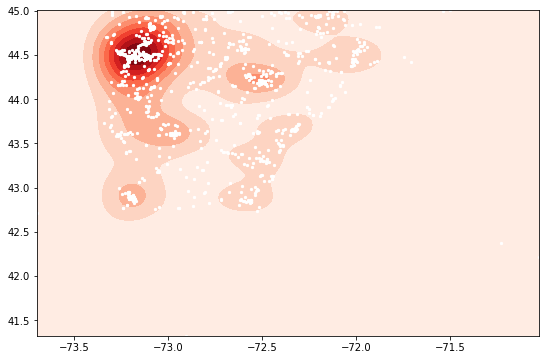

In [204]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.contourf(X, Y, scores_plot, levels = contour_levels, cmap = plt.cm.Reds)
ax.scatter(data['Lon'], data['Lat'], c = 'white', s = 5)
# # Optional x and y limits to zoom in on a portion of the graph
# xmin = -72.25
# xmax = -71.75
# ymin = 44.25
# ymax = 44.75
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
plt.show()

Note: It appears that this dataset only covers the top half of the state...

#### Optional table to zoom in on binned and scored x-y grid

In [199]:
scored_data = pd.DataFrame(xy, columns = ['Longitude', 'Latitude'])
scored_data['Score'] = scores

In [200]:
scored_data['Bin'] = pd.cut(scored_data['Score'], bins = contour_levels)

In [201]:
scored_data[(scored_data['Longitude'] > xmin) & (scored_data['Longitude'] < xmax) & (scored_data['Latitude'] > ymin) & (scored_data['Latitude'] < ymax)].sort_values(by = 'Longitude', ascending = False)

,Longitude,Latitude,Score,Bin
2072,-71.757435,44.267081,0.027363,"(0.0, 0.0445]"
1372,-71.757435,44.528031,0.074025,"(0.0445, 0.0891]"
872,-71.757435,44.714424,0.036525,"(0.0, 0.0445]"
1572,-71.757435,44.453474,0.075469,"(0.0445, 0.0891]"
1672,-71.757435,44.416195,0.069996,"(0.0445, 0.0891]"
...,...,...,...,...
1854,-72.243016,44.341638,0.221533,"(0.178, 0.223]"
1154,-72.243016,44.602588,0.213827,"(0.178, 0.223]"
2054,-72.243016,44.267081,0.185028,"(0.178, 0.223]"
1954,-72.243016,44.304360,0.202690,"(0.178, 0.223]"
